# Create Bike Behavior Groupings using k-means.

With no borough information, how does CitiBike behavior divide into sub-regions within these regions?

aggregate features grouped by end stations:
1. avg trip duration
1. std trip duration
1. avg trip duration peak
1. avg trip duration non-peak
1. avg trip duration by dow
1. avg trip duration on GOOD weather days
1. std trip duration on GOOD weather days
1. avg trip duration on BAD weather days
1. std trip duration on BAD weather days
1. avg crow flies distance
1. std crow flies distance
1. avg crow flies distance peak
1. avg crow flies distance non-peak
1. avg crow flies distance by dow
1. avg crow flies distance on GOOD weather days
1. std crow flies distance on GOOD weather days
1. avg crow flies distance on BAD weather days
1. std crow flies distance on BAD weather days
1. count trips by dow
1. count trips on peak/non-peak commute
1. count trips GOOD/BAD weather

All features will be MaxAbsScaler Scaled

In [2]:
import pandas as pd

from pyspark.sql import SparkSession

# load modules
import pandas as pd
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MaxAbsScaler
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import count, avg, stddev, col, udf, when, isnan, isnull
from pyspark.sql.functions import lit, concat
from pyspark.sql.types import DoubleType, StringType, IntegerType, StructType, StructField
import pyspark.sql.functions as F

# KMeans and Clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
    
from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.feature import *

# import modules
from functools import reduce
from pyspark.sql import DataFrame
import os
# start spark context
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("weatherwork") \
        .getOrCreate()
# set configurations
conf = SparkConf().setMaster("local[*]").setAppName("weatherwork")
sc = SparkContext.getOrCreate(conf=conf)

Read CSV I pulled from Abby's file; contains station info (lats, longs, address, etc.)

In [ ]:
df = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/master_dataset.parquet/')\
.select('month','dow','startStationLatitude','startStationLongitude','endStationLatitude','endStationLongitude','tripduration','startStationName','endStationName','peak_commute','feels_like', 'precip')

In [ ]:
df.show(2)
print(df.count())

# Add CrowFlies Distance to Each Trip

In [ ]:
# Necessary for distance calculations
from math import sin, cos, sqrt, atan2, radians    
from pyspark.sql.functions import col, radians, asin, sin, sqrt, cos

In [ ]:
# radius of earth in miles
R = 3963.0

#Convert start/end latitude and longitude from degrees to Radians
df = df.withColumn("startRadLong", radians(df.startStationLongitude))
df = df.withColumn("endRadLong", radians(df.endStationLongitude))
df = df.withColumn("startRadLat", radians(df.startStationLatitude))
df = df.withColumn("endRadLat", radians(df.endStationLatitude))
df = df.withColumn("diffRadLong", (df.startRadLong-df.endRadLong))
df = df.withColumn("diffRadLat", (df.startRadLat-df.endRadLat))
df = df.withColumn("crowDist", asin(sqrt(sin(df.diffRadLat/2)**2 + cos(df.startRadLat) * cos(df.endRadLat) * sin(df.diffRadLong/2)**2)) * 2 * R)
df = df.drop("startRadLong","endRadLong","startRadLat","endRadLat","diffRadLong","diffRadLat")

## ADD Weather Good/Bad Label to each trip

In [ ]:
# load the low and high rdds
schema = StructType([
    StructField("month", StringType(), True),
    StructField("feels_like", DoubleType(), True)])

df_low = spark.read.csv("/project/ds5559/Summer2021_TeamBike/broadcastLow.csv", header=False, schema=schema)

df_high = spark.read.csv("/project/ds5559/Summer2021_TeamBike/broadcastHigh.csv", header=False, schema=schema)

sdf_month_low = df_low.rdd.map(lambda x: (x[0], x[1])).collectAsMap()                                                       
bc_low = sc.broadcast(sdf_month_low)

sdf_month_high = df_high.rdd.map(lambda x: (x[0], x[1])).collectAsMap()                                                       
bc_high = sc.broadcast(sdf_month_high)
print(bc_high.value.get('Jun'))

@udf(returnType=StringType())
def goodOrBadWeatherTrip(input_month, input_feels_like, input_precip):
    # default value
    goodOrBad = "GOOD"
    if input_precip == "precip":
        goodOrBad = "BAD"
    elif input_feels_like >= bc_high.value.get(input_month) or input_feels_like <= bc_low.value.get(input_month):
        goodOrBad = "BAD"
   
    return goodOrBad

# join goodBadweather on master dataset
df = df.withColumn("weatherGOODorBAD", goodOrBadWeatherTrip(col("month"), col("feels_like"), col("precip"))).drop("feels_like","precip")
df.show(5)

## Are there nulls in the dataset?
**ANSWER:** Yes, there are nulls in end station information. I am removing those rows. Hypothesis is stolen bikes.

This removes 13,885 trips (a small fraction) from the dataframe.

** TO DO: take a look**

In [ ]:
df = df.filter(df.endStationLatitude. isNotNull())

## Calculate the aggregate feature for each endStationName that will be used for the model

aggregate features grouped by end stations:
1. avg trip duration
1. std trip duration
1. avg trip duration peak
1. avg trip duration non-peak
1. avg trip duration by dow
1. avg trip duration on GOOD weather days
1. std trip duration on GOOD weather days
1. avg trip duration on BAD weather days
1. std trip duration on BAD weather days
1. avg crow flies distance
1. std crow flies distance
1. avg crow flies distance peak
1. avg crow flies distance non-peak
1. avg crow flies distance by dow
1. avg crow flies distance on GOOD weather days
1. std crow flies distance on GOOD weather days
1. avg crow flies distance on BAD weather days
1. std crow flies distance on BAD weather days
1. count trips by dow
1. count trips on peak commute
1. count trips on non peak commute
1. count trips GOOD weather
1. count trips BAD weather

In [ ]:
# get basic averages for each station: average trip distance, average crow flies distance

df_endStation_Avg = df.groupBy("endStationName") \
    .agg(\
        avg("tripduration").alias("avg_tripduration"),\
        stddev("tripduration").alias("std_tripduration"),\
        avg("crowDist").alias("avg_crowDist"),\
        stddev("crowDist").alias("std_crowDist"))\
    .select("endStationName","avg_tripduration", "std_tripduration", "avg_crowDist", "std_crowDist")
    
print("Count of end stations: %s" % df_endStation_Avg.count())
df_endStation_Avg.show(5)

In [1]:
# test on a small sample of df
#df_sample = df.sample(0.01, 3)
#df_sample.cache()
#df_sample.count()

In [ ]:
# get the grouped by endStationName and good / bad weather - which we will need to pivot to put good bad weather as columns

df_grp_endStation_weather = df.groupBy("endStationName", "weatherGOODorBAD") \
    .agg(\
        avg("tripduration").alias("avg_td"),\
        stddev("tripduration").alias("std_td"),\
        count("tripduration").alias("cnt_td"),\
        avg("crowDist").alias("avg_dist"),\
        stddev("crowDist").alias("std_dist"))\
    .groupBy("endStationName")\
    .pivot("weatherGOODorBAD")\
    .agg(\
        avg("avg_td"),\
        avg("std_td"),\
        avg("cnt_td"),\
        avg("avg_dist"),\
        avg("std_dist"))\
    .withColumnRenamed("BAD_avg(avg_td)","avg_dur_BADweather")\
    .withColumnRenamed("BAD_avg(std_td)","std_dur_BADweather")\
    .withColumnRenamed("BAD_avg(cnt_td)","count_trips_BADweather")\
    .withColumnRenamed("BAD_avg(avg_dist)","avg_dist_BADweather")\
    .withColumnRenamed("BAD_avg(std_dist)","std_dist_BADweather")\
    .withColumnRenamed("GOOD_avg(avg_td)","avg_dur_GOODweather")\
    .withColumnRenamed("GOOD_avg(std_td)","std_dur_GOODweather")\
    .withColumnRenamed("GOOD_avg(cnt_td)","count_trips_GOODweather")\
    .withColumnRenamed("GOOD_avg(avg_dist)","avg_dist_GOODweather")\
    .withColumnRenamed("GOOD_avg(std_dist)","std_dist_GOODweather")
    
print("Count of end stations and weatherGOODorBAD: %s" % df_grp_endStation_weather.count())
df_grp_endStation_weather.show(5)

#### Save in-progress csv to SAVE work

In [ ]:
# join to the stations dataframe and save so I don't loose the work
df_endStation_Avg = df_endStation_Avg.join(df_grp_endStation_weather, 'endStationName', 'left')
df_endStation_Avg.show(5)

# write to csv
df_endStation_Avg.write.csv('NonBoroughKModels/stations_for_bikeBeahviorGroupingStep1.csv')

#### Load from the saved progress

In [ ]:
# load the low and high rdds
schema = StructType([
    StructField("endStationName", StringType(), True),
    StructField("avg_tripduration", DoubleType(), True),
    StructField("std_tripduration", DoubleType(), True),
    StructField("avg_crowDist", DoubleType(), True),
    StructField("std_crowDist", DoubleType(), True),
    StructField("avg_dur_BADweather", DoubleType(), True),
    StructField("std_dur_BADweather", DoubleType(), True),
    StructField("count_trips_BADweather", DoubleType(), True),
    StructField("avg_dist_BADweather", DoubleType(), True),
    StructField("std_dist_BADweather", DoubleType(), True),
    StructField("avg_dur_GOODweather", DoubleType(), True),
    StructField("std_dur_GOODweather", DoubleType(), True),
    StructField("count_trips_GOODweather", DoubleType(), True),
    StructField("avg_dist_GOODweather", DoubleType(), True),
    StructField("std_dist_GOODweather", DoubleType(), True)
])

df_endStation_Avg = spark.read.csv('NonBoroughKModels/stations_for_bikeBeahviorGroupingStep1.csv', header=False, schema=schema)
df_endStation_Avg.show(5)

In [ ]:
print("Count of end stations: %s" % df_endStation_Avg.count())

In [ ]:
# get the grouped by endStationName and peak, non peak - which we will need to pivot to put peak and non-peak as columns

df_grp_endStation_peak = df.groupBy("endStationName", "peak_commute") \
    .agg(\
        avg("tripduration").alias("avg_td"),\
        stddev("tripduration").alias("std_td"),\
        count("tripduration").alias("cnt_td"),\
        avg("crowDist").alias("avg_dist"),\
        stddev("crowDist").alias("std_dist"))\
    .groupBy("endStationName")\
    .pivot("peak_commute")\
    .agg(\
        avg("avg_td"),\
        avg("std_td"),\
        avg("cnt_td"),\
        avg("avg_dist"),\
        avg("std_dist")) \
    .withColumnRenamed("non_peak_avg(avg_td)","avg_dur_NONPEAK")\
    .withColumnRenamed("non_peak_avg(std_td)","std_dur_NONPEAK")\
    .withColumnRenamed("non_peak_avg(cnt_td)","count_trips_NONPEAK")\
    .withColumnRenamed("non_peak_avg(avg_dist)","avg_dist_NONPEAK")\
    .withColumnRenamed("non_peak_avg(std_dist)","std_dist_NONPEAK")\
    .withColumnRenamed("peak_avg(avg_td)","avg_dur_PEAK")\
    .withColumnRenamed("peak_avg(std_td)","std_dur_PEAK")\
    .withColumnRenamed("peak_avg(cnt_td)","count_trips_PEAK")\
    .withColumnRenamed("peak_avg(avg_dist)","avg_dist_PEAK")\
    .withColumnRenamed("peak_avg(std_dist)","std_dist_PEAK")

print("Count of end stations and peak / non-peak: %s" % df_grp_endStation_peak.count())
df_grp_endStation_peak.show(5)


In [ ]:
# join to the stations dataframe and save so I don't loose the work
df_endStation_Avg = df_endStation_Avg.join(df_grp_endStation_peak, 'endStationName', 'outer')
print("count of station rows: %s" % df_endStation_Avg.count())
df_endStation_Avg.show(5)



#### Save Progress

In [ ]:
# write to csv
df_endStation_Avg.write.csv('NonBoroughKModels/stations_for_bikeBeahviorGroupingStep2v2.csv', header=True)

#### Load Progress

In [ ]:

df_endStation_Avg = spark.read.csv('NonBoroughKModels/stations_for_bikeBeahviorGroupingStep2v2.csv', header=True)
df_endStation_Avg.show(5)

In [ ]:
# get the grouped by endStationName and dow - which we will need to pivot to put dow as columns

df_grp_endStation_dow = df.groupBy("endStationName", "dow") \
    .agg(\
        avg("tripduration").alias("avg_td"),\
        stddev("tripduration").alias("std_td"),\
        count("tripduration").alias("cnt_td"),\
        avg("crowDist").alias("avg_dist"),\
        stddev("crowDist").alias("std_dist"))\
    .groupBy("endStationName")\
    .pivot("dow")\
    .agg(\
        avg("avg_td"),\
        avg("std_td"),\
        avg("cnt_td"),\
        avg("avg_dist"),\
        avg("std_dist"))\
    .withColumnRenamed("1_avg(avg_td)","avg_dur_DOW1")\
    .withColumnRenamed("1_avg(std_td)","std_dur_DOW1")\
    .withColumnRenamed("1_avg(cnt_td)","count_trips_DOW1")\
    .withColumnRenamed("1_avg(avg_dist)","avg_dist_DOW1")\
    .withColumnRenamed("1_avg(std_dist)","std_dist_DOW1")\
    .withColumnRenamed("2_avg(avg_td)","avg_dur_DOW2")\
    .withColumnRenamed("2_avg(std_td)","std_dur_DOW2")\
    .withColumnRenamed("2_avg(cnt_td)","count_trips_DOW2")\
    .withColumnRenamed("2_avg(avg_dist)","avg_dist_DOW2")\
    .withColumnRenamed("2_avg(std_dist)","std_dist_DOW2")\
    .withColumnRenamed("3_avg(avg_td)","avg_dur_DOW3")\
    .withColumnRenamed("3_avg(std_td)","std_dur_DOW3")\
    .withColumnRenamed("3_avg(cnt_td)","count_trips_DOW3")\
    .withColumnRenamed("3_avg(avg_dist)","avg_dist_DOW3")\
    .withColumnRenamed("3_avg(std_dist)","std_dist_DOW3")\
    .withColumnRenamed("4_avg(avg_td)","avg_dur_DOW4")\
    .withColumnRenamed("4_avg(std_td)","std_dur_DOW4")\
    .withColumnRenamed("4_avg(cnt_td)","count_trips_DOW4")\
    .withColumnRenamed("4_avg(avg_dist)","avg_dist_DOW4")\
    .withColumnRenamed("4_avg(std_dist)","std_dist_DOW4")\
    .withColumnRenamed("5_avg(avg_td)","avg_dur_DOW5")\
    .withColumnRenamed("5_avg(std_td)","std_dur_DOW5")\
    .withColumnRenamed("5_avg(cnt_td)","count_trips_DOW5")\
    .withColumnRenamed("5_avg(avg_dist)","avg_dist_DOW5")\
    .withColumnRenamed("5_avg(std_dist)","std_dist_DOW5")\
    .withColumnRenamed("6_avg(avg_td)","avg_dur_DOW6")\
    .withColumnRenamed("6_avg(std_td)","std_dur_DOW6")\
    .withColumnRenamed("6_avg(cnt_td)","count_trips_DOW6")\
    .withColumnRenamed("6_avg(avg_dist)","avg_dist_DOW6")\
    .withColumnRenamed("6_avg(std_dist)","std_dist_DOW6")\
    .withColumnRenamed("7_avg(avg_td)","avg_dur_DOW7")\
    .withColumnRenamed("7_avg(std_td)","std_dur_DOW7")\
    .withColumnRenamed("7_avg(cnt_td)","count_trips_DOW7")\
    .withColumnRenamed("7_avg(avg_dist)","avg_dist_DOW7")\
    .withColumnRenamed("7_avg(std_dist)","std_dist_DOW7")
   
print("Count of end stations: %s" % df_grp_endStation_dow.count())
df_grp_endStation_dow.show(5)

In [ ]:
# join to the stations dataframe and save so I don't loose the work
df_endStation_Avg = df_endStation_Avg.join(df_grp_endStation_dow, 'endStationName', 'outer')
print("count of station rows: %s" % df_endStation_Avg.count())
df_endStation_Avg.show(5)

In [ ]:
# Repartition to a single partition
df_endStation_Avg = df_endStation_Avg.repartition(1)

In [ ]:
# write to csv
df_endStation_Avg.write.csv('NonBoroughKModels/stations_for_bikeBeahviorGroupingStep3.csv', header=True)

## Cache the dataset for reuse in the kmeans mod

In [2]:
# load from saved file

df_endStation_Avg = spark.read.csv('NonBoroughKModels/stations_for_bikeBeahviorGroupingStep3.csv', header=True)
df_endStation_Avg.show(5)

+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+-------------------+-------------------+-------------------+-------------------+-----------------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+---

In [15]:
# cache and count
df_endStation_Avg.cache()
print(df_endStation_Avg.count())

1634


In [13]:
# Need to deal with empty features and null features
df_endStation_Avg = df_endStation_Avg.na.fill(0).replace(float('nan'), 0)

columns = df_endStation_Avg.columns
for column in columns:
    df_endStation_Avg = df_endStation_Avg.withColumn(column,when(isnan(col(column)),0).otherwise(col(column))).withColumn(column,when(isnull(col(column)),0).otherwise(col(column)))
    
df_endStation_Avg.show(5)

+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+-------------------+-------------------+-------------------+-------------------+-----------------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+---

In [ ]:
df_endStation_Avg.show()

In [ ]:
# save the final version
df_endStation_Avg.write.csv('NonBoroughKModels/stations_for_bikeBeahviorGrouping-FINAL.csv', header=True)

## Pipeline For BikeBehavior Grouping
### Pipeline Steps

1. MaxAbsScaler Scale the data
2. KMeans with 3 - 25

In [22]:
schema = StructType([
    StructField("endStationName", StringType(), True),
    StructField("avg_tripduration", DoubleType(), True),
    StructField("std_tripduration", DoubleType(), True),
    StructField("avg_crowDist", DoubleType(), True),
    StructField("std_crowDist", DoubleType(), True),
    StructField("avg_dur_BADweather", DoubleType(), True),
    StructField("std_dur_BADweather", DoubleType(), True),
    StructField("count_trips_BADweather", DoubleType(), True),
    StructField("avg_dist_BADweather", DoubleType(), True),
    StructField("std_dist_BADweather", DoubleType(), True),
    StructField("avg_dur_GOODweather", DoubleType(), True),
    StructField("std_dur_GOODweather", DoubleType(), True),
    StructField("count_trips_GOODweather", DoubleType(), True),
    StructField("avg_dist_GOODweather", DoubleType(), True),
    StructField("std_dist_GOODweather", DoubleType(), True),
    StructField("avg_dur_NONPEAK", DoubleType(), True),
    StructField("std_dur_NONPEAK", DoubleType(), True),
    StructField("count_trips_NONPEAK", DoubleType(), True),
    StructField("avg_dist_NONPEAK", DoubleType(), True),
    StructField("std_dist_NONPEAK", DoubleType(), True),
    StructField("avg_dur_PEAK", DoubleType(), True),
    StructField("std_dur_PEAK", DoubleType(), True),
    StructField("count_trips_PEAK", DoubleType(), True),
    StructField("avg_dist_PEAK", DoubleType(), True),
    StructField("std_dist_PEAK", DoubleType(), True),    
    StructField("avg_dur_DOW1", DoubleType(), True),
    StructField("std_dur_DOW1", DoubleType(), True),
    StructField("count_trips_DOW1", DoubleType(), True),
    StructField("avg_dist_DOW1", DoubleType(), True),
    StructField("std_dist_DOW1", DoubleType(), True),    
    StructField("avg_dur_DOW2", DoubleType(), True),
    StructField("std_dur_DOW2", DoubleType(), True),
    StructField("count_trips_DOW2", DoubleType(), True),
    StructField("avg_dist_DOW2", DoubleType(), True),
    StructField("std_dist_DOW2", DoubleType(), True),    
    StructField("avg_dur_DOW3", DoubleType(), True),
    StructField("std_dur_DOW3", DoubleType(), True),
    StructField("count_trips_DOW3", DoubleType(), True),
    StructField("avg_dist_DOW3", DoubleType(), True),
    StructField("std_dist_DOW3", DoubleType(), True),    
    StructField("avg_dur_DOW4", DoubleType(), True),
    StructField("std_dur_DOW4", DoubleType(), True),
    StructField("count_trips_DOW4", DoubleType(), True),
    StructField("avg_dist_DOW4", DoubleType(), True),
    StructField("std_dist_DOW4", DoubleType(), True),    
    StructField("avg_dur_DOW5", DoubleType(), True),
    StructField("std_dur_DOW5", DoubleType(), True),
    StructField("count_trips_DOW5", DoubleType(), True),
    StructField("avg_dist_DOW5", DoubleType(), True),
    StructField("std_dist_DOW5", DoubleType(), True),    
    StructField("avg_dur_DOW6", DoubleType(), True),
    StructField("std_dur_DOW6", DoubleType(), True),
    StructField("count_trips_DOW6", DoubleType(), True),
    StructField("avg_dist_DOW6", DoubleType(), True),
    StructField("std_dist_DOW6", DoubleType(), True),    
    StructField("avg_dur_DOW7", DoubleType(), True),
    StructField("std_dur_DOW7", DoubleType(), True),
    StructField("count_trips_DOW7", DoubleType(), True),
    StructField("avg_dist_DOW7", DoubleType(), True),
    StructField("std_dist_DOW7", DoubleType(), True)
])

df_endStation_Avg = spark.read.csv('NonBoroughKModels/stations_for_bikeBeahviorGrouping-FINAL.csv', header=True, schema = schema)
df_endStation_Avg.show(5)

+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+-------------------+-------------------+-------------------+-------------------+-----------------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+----------------+------------------+------------------+------------------+------------------+---

In [23]:
columns = df_endStation_Avg.columns
print(columns)

['endStationName', 'avg_tripduration', 'std_tripduration', 'avg_crowDist', 'std_crowDist', 'avg_dur_BADweather', 'std_dur_BADweather', 'count_trips_BADweather', 'avg_dist_BADweather', 'std_dist_BADweather', 'avg_dur_GOODweather', 'std_dur_GOODweather', 'count_trips_GOODweather', 'avg_dist_GOODweather', 'std_dist_GOODweather', 'avg_dur_NONPEAK', 'std_dur_NONPEAK', 'count_trips_NONPEAK', 'avg_dist_NONPEAK', 'std_dist_NONPEAK', 'avg_dur_PEAK', 'std_dur_PEAK', 'count_trips_PEAK', 'avg_dist_PEAK', 'std_dist_PEAK', 'avg_dur_DOW1', 'std_dur_DOW1', 'count_trips_DOW1', 'avg_dist_DOW1', 'std_dist_DOW1', 'avg_dur_DOW2', 'std_dur_DOW2', 'count_trips_DOW2', 'avg_dist_DOW2', 'std_dist_DOW2', 'avg_dur_DOW3', 'std_dur_DOW3', 'count_trips_DOW3', 'avg_dist_DOW3', 'std_dist_DOW3', 'avg_dur_DOW4', 'std_dur_DOW4', 'count_trips_DOW4', 'avg_dist_DOW4', 'std_dist_DOW4', 'avg_dur_DOW5', 'std_dur_DOW5', 'count_trips_DOW5', 'avg_dist_DOW5', 'std_dist_DOW5', 'avg_dur_DOW6', 'std_dur_DOW6', 'count_trips_DOW6', 'av

In [66]:
# STEP 1: Vector Assembler
va = VectorAssembler(inputCols=['avg_tripduration', 'std_tripduration', 'avg_crowDist', 'std_crowDist', 'avg_dur_BADweather', \
                                'std_dur_BADweather', 'count_trips_BADweather', 'avg_dist_BADweather', 'std_dist_BADweather', 'avg_dur_GOODweather', \
                                'std_dur_GOODweather', 'count_trips_GOODweather', 'avg_dist_GOODweather', 'std_dist_GOODweather', 'avg_dur_NONPEAK', \
                                'std_dur_NONPEAK', 'count_trips_NONPEAK', 'avg_dist_NONPEAK', 'std_dist_NONPEAK', 'avg_dur_PEAK', 'std_dur_PEAK', 'count_trips_PEAK', \
                                'avg_dist_PEAK', 'std_dist_PEAK', 'avg_dur_DOW1', 'std_dur_DOW1', 'count_trips_DOW1', 'avg_dist_DOW1', 'std_dist_DOW1', 'avg_dur_DOW2', \
                                'std_dur_DOW2', 'count_trips_DOW2', 'avg_dist_DOW2', 'std_dist_DOW2', 'avg_dur_DOW3', 'std_dur_DOW3', 'count_trips_DOW3', 'avg_dist_DOW3', \
                                'std_dist_DOW3', 'avg_dur_DOW4', 'std_dur_DOW4', 'count_trips_DOW4', 'avg_dist_DOW4', 'std_dist_DOW4', 'avg_dur_DOW5', 'std_dur_DOW5', \
                                'count_trips_DOW5', 'avg_dist_DOW5', 'std_dist_DOW5', 'avg_dur_DOW6', 'std_dur_DOW6', 'count_trips_DOW6', 'avg_dist_DOW6', 'std_dist_DOW6', \
                                'avg_dur_DOW7', 'std_dur_DOW7', 'count_trips_DOW7', 'avg_dist_DOW7', 'std_dist_DOW7'], outputCol="features") 

# STEP 2: MaxAbsScaler the numeric variables
scaler = MaxAbsScaler(inputCol="features", outputCol="featuresScaled")

#for k in [2]:
for k in [19]:
    # STEP 3: KMeans Model
    kmeans = KMeans().setK(k).setSeed(314).setMaxIter(500)
    # Build the pipeline; this takes the objects as inputs
    pipeline = Pipeline(stages=[va, scaler, kmeans])
    
    # Fit the pipeline
    pipe = pipeline.fit(df_endStation_Avg)
    
    # save the pipeline
    pipe.save('NonBoroughKModels/kMEANS_BikeBehavior{}_pipeline'.format(k))


In [68]:
# Evaluate the no_mb clusters
evaluator = ClusteringEvaluator()
ks = []
sils = []
data_tuning = {}

for k in [19]:
    pipe = PipelineModel.load("NonBoroughKModels/kMEANS_BikeBehavior{}_pipeline".format(k))
    
    predictions = pipe.transform(df_endStation_Avg)
    silhouette = evaluator.evaluate(predictions)
    ks.append(k)
    sils.append(silhouette)
     # save the predictions
    predictions.write.mode("overwrite").parquet('NonBoroughKModels/kMEANS_BikeBehavior{}_Predictions.parquet'.format(k))
    

data_tuning = {'k' : ks, 'silouhette' : sils}
df_tuning = pd.DataFrame(data = data_tuning, columns=['k','silouhette'])

In [69]:
df_tuning.head(23)

,k,silouhette
0,3,0.993487
1,4,0.984541
2,5,0.989651
3,6,0.981637
4,7,0.981385
5,8,0.451987
6,9,0.624739
7,10,0.608149
8,11,0.595409
9,12,0.582118


k's of 3 - 7 are similar. It is interesting that there is a bump in silouhette score between 8 and 9.

**But the best k is 3; however it provides very poor distribution.**
Look below at the distributions of interesting k's

In [70]:
#df_Predictions_k3 = spark.read.parquet('NonBoroughKModels/kMEANS_BikeBehavior3_Predictions.parquet').select('endStationName','prediction')
#df_Predictions_k9 = spark.read.parquet('NonBoroughKModels/kMEANS_BikeBehavior9_Predictions.parquet').select('endStationName','prediction')
df_Predictions_k19 = spark.read.parquet('NonBoroughKModels/kMEANS_BikeBehavior19_Predictions.parquet').select('endStationName','prediction')
#df_Predictions_k23 = spark.read.parquet('NonBoroughKModels/kMEANS_BikeBehavior23_Predictions.parquet').select('endStationName','prediction')


In [71]:
df_Predictions_k3.groupBy('prediction').agg(\
        count("endStationName")).show()

+----------+---------------------+
|prediction|count(endStationName)|
+----------+---------------------+
|         1|                    4|
|         2|                    1|
|         0|                 1629|
+----------+---------------------+



In [72]:
df_Predictions_k9.groupBy('prediction').agg(\
        count("endStationName")).show()

+----------+---------------------+
|prediction|count(endStationName)|
+----------+---------------------+
|         1|                    1|
|         6|                    1|
|         3|                    1|
|         5|                    1|
|         4|                  268|
|         8|                    2|
|         7|                 1255|
|         2|                    1|
|         0|                  104|
+----------+---------------------+



In [78]:
df_Predictions_k19.groupBy('prediction').agg(\
        count("endStationName")).orderBy('count(endStationName)').show()

+----------+---------------------+
|prediction|count(endStationName)|
+----------+---------------------+
|        16|                    1|
|         8|                    1|
|        10|                    1|
|         5|                    1|
|         6|                    1|
|         2|                    1|
|         1|                    1|
|        18|                    1|
|        11|                    2|
|         4|                    2|
|        12|                    3|
|         3|                   17|
|         9|                   23|
|        14|                   37|
|         0|                   70|
|         7|                  146|
|        17|                  287|
|        15|                  297|
|        13|                  742|
+----------+---------------------+



In [77]:
df_Predictions_k23.groupBy('prediction').agg(\
        count("endStationName")).orderBy('count(endStationName)').show()

+----------+---------------------+
|prediction|count(endStationName)|
+----------+---------------------+
|        19|                    1|
|         2|                    1|
|         6|                    1|
|         1|                    1|
|         4|                    1|
|         3|                    1|
|        22|                    1|
|         5|                    1|
|        11|                    1|
|        14|                    1|
|        18|                    1|
|        16|                    2|
|        10|                    2|
|        20|                    7|
|         0|                   14|
|        12|                   21|
|        17|                   58|
|        21|                   60|
|        15|                   85|
|         7|                  162|
+----------+---------------------+
only showing top 20 rows



In [120]:
df_Predictions_k19.groupBy('prediction').agg(\
        count("endStationName")).orderBy('count(endStationName)').show()

+----------+---------------------+
|prediction|count(endStationName)|
+----------+---------------------+
|        16|                    1|
|         8|                    1|
|        10|                    1|
|         5|                    1|
|         6|                    1|
|         2|                    1|
|         1|                    1|
|        18|                    1|
|        11|                    2|
|         4|                    2|
|        12|                    3|
|         3|                   17|
|         9|                   23|
|        14|                   37|
|         0|                   70|
|         7|                  146|
|        17|                  287|
|        15|                  297|
|        13|                  742|
+----------+---------------------+



While k == 19 doesn't have the highest silouhette score, it does divide stations into more equal groupings that are more interesting.
I am going to set the following groupings of predictions:

1. Group 13 == 0 (742 stations)
1. Group 15 == 1 (297 stations)
1. Group 17 == 2 (287 stations)
1. Group 7 == 3 (146 stations)
1. Group 0 == 4 (70 stations)
1. Group 14 == 5 (37 stations)
1. Group 9 == 6 (23 stations)
1. Groups 3, 12, 4, 11, 18, 1, 2, 6, 5, 10, 8, and 16 are all going to be thought of as 'ungrouped' and will be assigned -1

In [137]:

df_Groupings = df_Predictions_k19.withColumn("bikeBehaviorGroup", F.when(col("prediction") == 13, 0)\
                                        .otherwise(F.when(col("prediction") == 15, 1)\
                                        .otherwise(F.when(col("prediction") == 17, 2)\
                                        .otherwise(F.when(col("prediction") == 7, 3)\
                                        .otherwise(F.when(col("prediction") == 0, 4)\
                                        .otherwise(F.when(col("prediction") == 14, 5)\
                                        .otherwise(F.when(col("prediction") == 9, 6)\
                                        .otherwise(F.when(col("prediction").isin(3,12,4,11,18,1,2,6,5,10,8,16), -1)\
                                        .otherwise(-1)\
                                                  ))))))))

df_Groupings.groupBy('bikeBehaviorGroup').agg(\
        count("endStationName")).orderBy('count(endStationName)').orderBy('bikeBehaviorGroup').show()

+-----------------+---------------------+
|bikeBehaviorGroup|count(endStationName)|
+-----------------+---------------------+
|               -1|                   32|
|                0|                  742|
|                1|                  297|
|                2|                  287|
|                3|                  146|
|                4|                   70|
|                5|                   37|
|                6|                   23|
+-----------------+---------------------+



In [138]:
df_Groupings = df_Groupings.drop('prediction')

In [139]:
df_Groupings.show(5)

+--------------------+-----------------+
|      endStationName|bikeBehaviorGroup|
+--------------------+-----------------+
|       10 St & 5 Ave|                0|
|       19 St & 8 Ave|                0|
|       45 Rd & 11 St|                0|
|       5 Ave & 66 St|                0|
|Clinton St	& Cher...|                0|
+--------------------+-----------------+
only showing top 5 rows



# Assemble the dataframe with unique bikeBeahviorGroup based on best k's



In [140]:
# join with the dataframe of locations with endStationLatitude endStationLongitude
df = spark.read.parquet('/project/ds5559/Summer2021_TeamBike/master_dataset.parquet/')\
.select('endStationName','endStationLatitude','endStationLongitude').distinct().groupBy('endStationName').agg(\
        avg("endStationLatitude").alias("latitude"),\
        avg("endStationLongitude").alias("longitude"))

print(df.count())
df.show(5)

1632
+--------------------+------------------+------------------+
|      endStationName|          latitude|         longitude|
+--------------------+------------------+------------------+
|       10 St & 5 Ave|       40.66862715|     -73.987000765|
|  N 11 St & Kent Ave|  40.7224819431911|-73.95921915335367|
|       5 Ave & 66 St|40.635678999999996|        -74.020005|
|E 141 St & Jackso...|         40.806896|        -73.911837|
|Clinton St	& Cher...|         40.711471|        -73.986726|
+--------------------+------------------+------------------+
only showing top 5 rows



In [141]:
#join the bikeBehaviorLabels to the endStationNames
df = df.join(df_Groupings,'endStationName', 'left')
print(df.count())
df.show(5)

1632
+--------------------+------------------+------------------+-----------------+
|      endStationName|          latitude|         longitude|bikeBehaviorGroup|
+--------------------+------------------+------------------+-----------------+
|       10 St & 5 Ave|       40.66862715|     -73.987000765|                0|
|  N 11 St & Kent Ave|  40.7224819431911|-73.95921915335367|                0|
|       5 Ave & 66 St|40.635678999999996|        -74.020005|                0|
|E 141 St & Jackso...|         40.806896|        -73.911837|                2|
|Clinton St	& Cher...|         40.711471|        -73.986726|                0|
+--------------------+------------------+------------------+-----------------+
only showing top 5 rows



In [142]:
# write the stations with average lat and average lon with bikeBehaviorGroup to csv
df.write.mode('overwrite').csv('NonBoroughKModels/endStationNameLatLonNoLocationBikeBehaviorGroup.csv', header=True)

# Save the dataframe as parquet or csv with startStationName, Lat, Lon, and bikeBehaviorGroup

Send to pandas. Need in pandas form for graphing:

In [3]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType

schema = StructType([
    StructField("endStationName", StringType(), True),
    StructField("latitude", DoubleType(), True),
    StructField("longitude", DoubleType(), True),
    StructField("bikeBehaviorGroup", IntegerType(), True)
])

df_s = spark.read.csv("NonBoroughKModels/endStationNameLatLonNoLocationBikeBehaviorGroup.csv", header=True,schema=schema)

# remove nans and nulls
df_s = df_s.filter(df_s.bikeBehaviorGroup. isNotNull())
df_p = df_s.toPandas()
df_p["bikeBehaviorGroup"] = df_p["bikeBehaviorGroup"].astype(int).astype(str)
df_p = df_p.sort_values(by='bikeBehaviorGroup', ascending=False)
df_p.head()

,endStationName,latitude,longitude,bikeBehaviorGroup
698,E 161 St & Park Ave,40.824811,-73.916407,6
647,Putnam Ave & Knickerbocker Ave,40.695450,-73.911640,6
1524,48 St & 37 Ave,40.751555,-73.915026,6
1502,Courtlandt Ave & E 157 St,40.822267,-73.916792,6
1500,St. Ann's Ave & E 144 St,40.811556,-73.914466,6


In [4]:
df_p.groupby(
    ['bikeBehaviorGroup'], as_index=False).agg(
    {'count'}
)

,endStationName,latitude,longitude
,count,count,count
bikeBehaviorGroup,,,
-1,32,32,32
0,740,740,740
1,297,297,297
2,286,286,286
3,146,146,146
4,70,70,70
5,37,37,37
6,23,23,23


Plot:

In [5]:
import plotly.express as px

In [8]:
fig = px.scatter(df_p, x = 'longitude', y = 'latitude', color='bikeBehaviorGroup', color_discrete_sequence=px.colors.qualitative.G10,
                 hover_data=['bikeBehaviorGroup'], height=800, title='End Station Bike Behavior Group')

In [9]:
df_s.groupBy('bikeBehaviorGroup').agg(\
        count("endStationName")).orderBy('count(endStationName)').orderBy('bikeBehaviorGroup').show()

+-----------------+---------------------+
|bikeBehaviorGroup|count(endStationName)|
+-----------------+---------------------+
|               -1|                   32|
|                0|                  740|
|                1|                  297|
|                2|                  286|
|                3|                  146|
|                4|                   70|
|                5|                   37|
|                6|                   23|
+-----------------+---------------------+



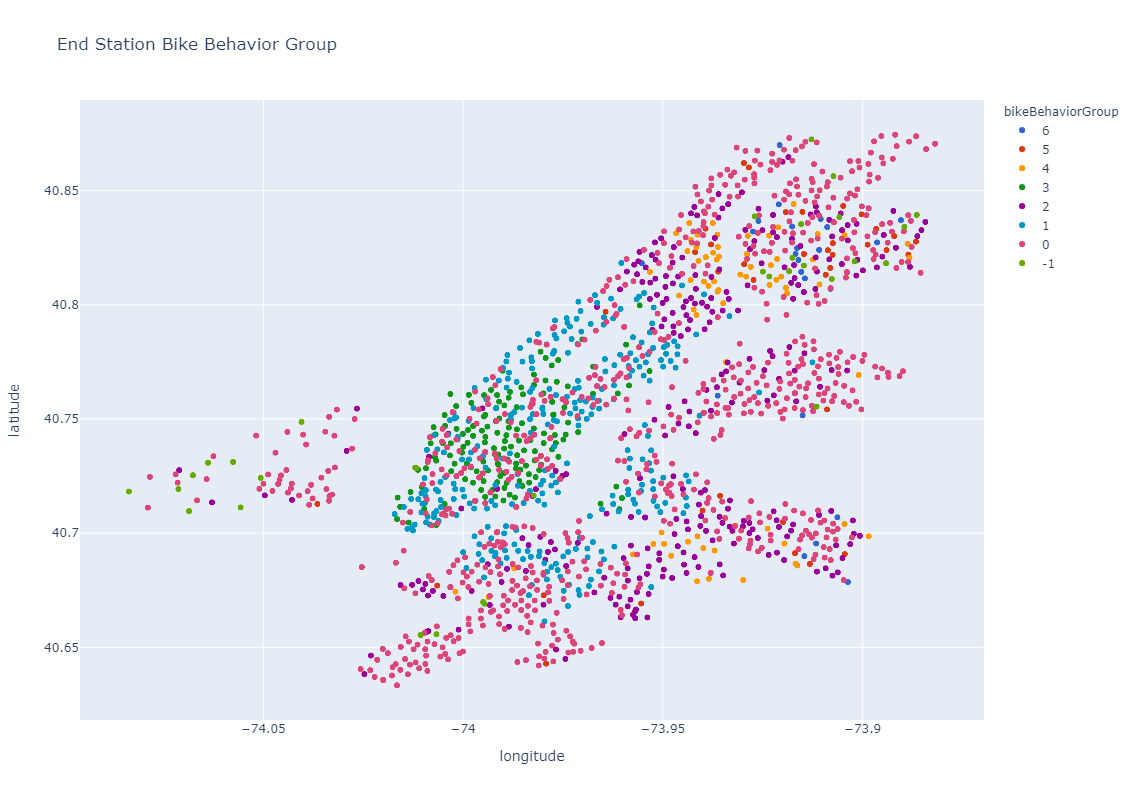

In [10]:

fig.show()

### Observations on map of bikeBehaviorGroups of trips:

# NEED TO DO

In [34]:
df_p.count()

endStationName       1631
latitude             1631
longitude            1631
bikeBehaviorGroup    1631
dtype: int64

In [37]:
df_p.head()

,endStationName,latitude,longitude,bikeBehaviorGroup
0,Bedford Ave & S 9 St,40.708531,-73.964090,2
1,6 Ave & 21 St,40.660160,-73.990974,0
2,2 Ave & E 104 St,40.789211,-73.943708,2
3,W 50 St & 10 Ave,40.764734,-73.991944,0
4,Monmouth and 6th,40.725685,-74.048790,0


In [39]:
df_p.to_csv('/project/ds5559/Summer2021_TeamBike/station_bikeBehaviorNoBoroughGroup-FINAL.csv', index=False)

# Data for observations about the groupings

In [31]:
# save the final version
df_AggStationData = pd.read_csv('NonBoroughKModels/stations_for_bikeBeahviorGrouping-FINAL.csv/part-00000-0bf3c7e4-ff88-42ad-867b-5ee0171331b3-c000.csv')
df_AggStationData.head()

,endStationName,avg_tripduration,std_tripduration,avg_crowDist,std_crowDist,avg_dur_BADweather,std_dur_BADweather,count_trips_BADweather,avg_dist_BADweather,std_dist_BADweather,avg_dur_GOODweather,std_dur_GOODweather,count_trips_GOODweather,avg_dist_GOODweather,std_dist_GOODweather,avg_dur_NONPEAK,std_dur_NONPEAK,count_trips_NONPEAK,avg_dist_NONPEAK,std_dist_NONPEAK,avg_dur_PEAK,std_dur_PEAK,count_trips_PEAK,avg_dist_PEAK,std_dist_PEAK,avg_dur_DOW1,std_dur_DOW1,count_trips_DOW1,avg_dist_DOW1,std_dist_DOW1,avg_dur_DOW2,std_dur_DOW2,count_trips_DOW2,avg_dist_DOW2,std_dist_DOW2,avg_dur_DOW3,std_dur_DOW3,count_trips_DOW3,avg_dist_DOW3,std_dist_DOW3,avg_dur_DOW4,std_dur_DOW4,count_trips_DOW4,avg_dist_DOW4,std_dist_DOW4,avg_dur_DOW5,std_dur_DOW5,count_trips_DOW5,avg_dist_DOW5,std_dist_DOW5,avg_dur_DOW6,std_dur_DOW6,count_trips_DOW6,avg_dist_DOW6,std_dist_DOW6,avg_dur_DOW7,std_dur_DOW7,count_trips_DOW7,avg_dist_DOW7,std_dist_DOW7
0,10 St & 5 Ave,986.815843,4183.423639,1.063604,1.047632,893.622556,3355.218442,5728.0,1.008089,0.999273,1029.259283,4509.980276,12577.0,1.088887,1.068015,1006.566400,3993.980164,11619.0,1.042751,0.981877,952.493120,4493.785157,6686.0,1.099841,1.152196,1202.006904,6405.434322,2752.0,1.039136,0.913167,927.429050,2547.785551,2389.0,1.063839,1.096463,992.416839,4313.675420,2411.0,1.128840,1.171623,1035.301392,6132.526383,2515.0,1.064071,1.048948,854.552829,2240.445865,2527.0,1.019177,1.032388,853.700938,2118.597520,2558.0,1.058038,1.042828,1015.030447,2990.261673,3153.0,1.074646,1.032414
1,19 St & 8 Ave,1073.608333,2764.440990,1.218821,1.309428,761.896552,587.401016,29.0,1.254362,1.406052,1172.945055,3155.307864,91.0,1.207494,1.285102,1325.876923,3697.715230,65.0,1.307390,1.458702,775.472727,684.625441,55.0,1.114148,1.111766,2683.894737,6663.790570,19.0,1.650472,1.491947,621.555556,526.275618,18.0,0.700971,1.025727,786.500000,911.152938,18.0,0.871307,0.961451,745.312500,502.866811,16.0,1.012653,0.987074,750.095238,563.267069,21.0,1.397593,1.284093,654.642857,546.901989,14.0,1.219531,1.200301,1118.000000,1123.816232,14.0,1.712367,1.936420
2,45 Rd & 11 St,927.397715,1975.887216,1.255151,1.186502,818.566720,996.652013,9982.0,1.207490,1.179966,977.859950,2290.387141,21528.0,1.277250,1.188900,992.126369,1848.742171,17536.0,1.245473,1.154181,846.169601,2121.979973,13974.0,1.267295,1.225791,1024.148309,1658.145010,4376.0,1.316486,1.178053,844.757257,1346.891496,3996.0,1.223924,1.216394,844.223847,2126.208605,4445.0,1.214089,1.197741,906.870238,2966.169375,4462.0,1.187912,1.146780,883.715932,2092.921504,4425.0,1.218432,1.177147,865.671599,775.885362,4528.0,1.206395,1.182351,1086.726980,2043.482682,5278.0,1.391977,1.193039
3,5 Ave & 66 St,1716.461812,3066.367683,1.238018,1.736804,2199.589744,5559.434530,117.0,1.279861,1.720202,1589.721973,1934.050683,446.0,1.227041,1.742884,1846.137566,3527.507766,378.0,1.402622,1.776763,1451.502703,1765.913673,185.0,0.901690,1.604935,1473.289720,1242.038639,107.0,1.112050,1.667618,1781.052632,2577.620209,76.0,1.389976,1.919040,1573.132353,1493.239041,68.0,1.054012,1.664799,1599.826087,1781.254201,69.0,0.922734,1.489994,2630.307692,7377.557160,65.0,1.502179,1.701132,1664.644737,2014.680770,76.0,1.251877,1.780572,1554.137255,1998.261735,102.0,1.414221,1.846326
4,Clinton St\t& Cherry St,2052.305638,7821.219477,1.166931,0.819850,1306.242105,1532.756602,95.0,1.209391,1.054698,2345.181818,9168.578207,242.0,1.150263,0.708692,2345.700000,8878.081632,260.0,1.165890,0.826774,1061.623377,736.245026,77.0,1.170448,0.801328,2624.898305,9686.631012,59.0,1.152138,0.685486,1007.980769,688.826894,52.0,1.139937,0.870201,1412.312500,2238.415013,32.0,1.113677,0.799617,3323.205882,14154.083492,34.0,0.916236,0.444882,1252.675000,1174.468290,40.0,1.395543,1.180286,1403.277778,1613.098991,54.0,1.143158,0.893752,3034.484848,11005.571795,66.0,1.237286,0.704118


In [13]:
df_grouping = pd.read_csv('/project/ds5559/Summer2021_TeamBike/station_bikeBehaviorNoBoroughGroup-FINAL.csv')
df_grouping = df_grouping[['endStationName','bikeBehaviorGroup']]
df_grouping.head()

,endStationName,bikeBehaviorGroup
0,Bedford Ave & S 9 St,2
1,6 Ave & 21 St,0
2,2 Ave & E 104 St,2
3,W 50 St & 10 Ave,0
4,Monmouth and 6th,0


In [26]:
df_join = df_AggStationData.merge(df_grouping, how="left", on="endStationName")
pd.set_option("display.max_columns", None)
df_join.head()

,endStationName,avg_tripduration,std_tripduration,avg_crowDist,std_crowDist,avg_dur_BADweather,std_dur_BADweather,count_trips_BADweather,avg_dist_BADweather,std_dist_BADweather,avg_dur_GOODweather,std_dur_GOODweather,count_trips_GOODweather,avg_dist_GOODweather,std_dist_GOODweather,avg_dur_NONPEAK,std_dur_NONPEAK,count_trips_NONPEAK,avg_dist_NONPEAK,std_dist_NONPEAK,avg_dur_PEAK,std_dur_PEAK,count_trips_PEAK,avg_dist_PEAK,std_dist_PEAK,avg_dur_DOW1,std_dur_DOW1,count_trips_DOW1,avg_dist_DOW1,std_dist_DOW1,avg_dur_DOW2,std_dur_DOW2,count_trips_DOW2,avg_dist_DOW2,std_dist_DOW2,avg_dur_DOW3,std_dur_DOW3,count_trips_DOW3,avg_dist_DOW3,std_dist_DOW3,avg_dur_DOW4,std_dur_DOW4,count_trips_DOW4,avg_dist_DOW4,std_dist_DOW4,avg_dur_DOW5,std_dur_DOW5,count_trips_DOW5,avg_dist_DOW5,std_dist_DOW5,avg_dur_DOW6,std_dur_DOW6,count_trips_DOW6,avg_dist_DOW6,std_dist_DOW6,avg_dur_DOW7,std_dur_DOW7,count_trips_DOW7,avg_dist_DOW7,std_dist_DOW7,bikeBehaviorGroup
0,10 St & 5 Ave,986.815843,4183.423639,1.063604,1.047632,893.622556,3355.218442,5728.0,1.008089,0.999273,1029.259283,4509.980276,12577.0,1.088887,1.068015,1006.566400,3993.980164,11619.0,1.042751,0.981877,952.493120,4493.785157,6686.0,1.099841,1.152196,1202.006904,6405.434322,2752.0,1.039136,0.913167,927.429050,2547.785551,2389.0,1.063839,1.096463,992.416839,4313.675420,2411.0,1.128840,1.171623,1035.301392,6132.526383,2515.0,1.064071,1.048948,854.552829,2240.445865,2527.0,1.019177,1.032388,853.700938,2118.597520,2558.0,1.058038,1.042828,1015.030447,2990.261673,3153.0,1.074646,1.032414,0.0
1,19 St & 8 Ave,1073.608333,2764.440990,1.218821,1.309428,761.896552,587.401016,29.0,1.254362,1.406052,1172.945055,3155.307864,91.0,1.207494,1.285102,1325.876923,3697.715230,65.0,1.307390,1.458702,775.472727,684.625441,55.0,1.114148,1.111766,2683.894737,6663.790570,19.0,1.650472,1.491947,621.555556,526.275618,18.0,0.700971,1.025727,786.500000,911.152938,18.0,0.871307,0.961451,745.312500,502.866811,16.0,1.012653,0.987074,750.095238,563.267069,21.0,1.397593,1.284093,654.642857,546.901989,14.0,1.219531,1.200301,1118.000000,1123.816232,14.0,1.712367,1.936420,0.0
2,45 Rd & 11 St,927.397715,1975.887216,1.255151,1.186502,818.566720,996.652013,9982.0,1.207490,1.179966,977.859950,2290.387141,21528.0,1.277250,1.188900,992.126369,1848.742171,17536.0,1.245473,1.154181,846.169601,2121.979973,13974.0,1.267295,1.225791,1024.148309,1658.145010,4376.0,1.316486,1.178053,844.757257,1346.891496,3996.0,1.223924,1.216394,844.223847,2126.208605,4445.0,1.214089,1.197741,906.870238,2966.169375,4462.0,1.187912,1.146780,883.715932,2092.921504,4425.0,1.218432,1.177147,865.671599,775.885362,4528.0,1.206395,1.182351,1086.726980,2043.482682,5278.0,1.391977,1.193039,0.0
3,5 Ave & 66 St,1716.461812,3066.367683,1.238018,1.736804,2199.589744,5559.434530,117.0,1.279861,1.720202,1589.721973,1934.050683,446.0,1.227041,1.742884,1846.137566,3527.507766,378.0,1.402622,1.776763,1451.502703,1765.913673,185.0,0.901690,1.604935,1473.289720,1242.038639,107.0,1.112050,1.667618,1781.052632,2577.620209,76.0,1.389976,1.919040,1573.132353,1493.239041,68.0,1.054012,1.664799,1599.826087,1781.254201,69.0,0.922734,1.489994,2630.307692,7377.557160,65.0,1.502179,1.701132,1664.644737,2014.680770,76.0,1.251877,1.780572,1554.137255,1998.261735,102.0,1.414221,1.846326,0.0
4,Clinton St\t& Cherry St,2052.305638,7821.219477,1.166931,0.819850,1306.242105,1532.756602,95.0,1.209391,1.054698,2345.181818,9168.578207,242.0,1.150263,0.708692,2345.700000,8878.081632,260.0,1.165890,0.826774,1061.623377,736.245026,77.0,1.170448,0.801328,2624.898305,9686.631012,59.0,1.152138,0.685486,1007.980769,688.826894,52.0,1.139937,0.870201,1412.312500,2238.415013,32.0,1.113677,0.799617,3323.205882,14154.083492,34.0,0.916236,0.444882,1252.675000,1174.468290,40.0,1.395543,1.180286,1403.277778,1613.098991,54.0,1.143158,0.893752,3034.484848,11005.571795,66.0,1.237286,0.704118,0.0


In [27]:
df_join.groupby(['bikeBehaviorGroup'])\
    .agg({'avg_tripduration': ['mean', 'std'],\
          'avg_crowDist': ['mean', 'std'],\
          'avg_dur_BADweather': ['mean', 'std'],\
          'count_trips_BADweather': ['mean', 'std'],\
          'avg_dist_BADweather': ['mean', 'std'],\
          'avg_dur_GOODweather': ['mean', 'std'],\
          'count_trips_GOODweather': ['mean', 'std'],\
          'avg_dist_GOODweather': ['mean', 'std'],\
          'avg_dist_GOODweather': ['mean', 'std']\
         }).reset_index()

bikeBehaviorGroup avg_tripduration                avg_crowDist            \
                                mean            std         mean       std   
0              -1.0    169989.016183  300657.233361     2.486737  2.011096   
1               0.0      1788.894119    4929.452445     1.366452  0.943031   
2               1.0      1058.797984     200.520832     1.198310  0.214085   
3               2.0      2547.657976    5329.598469     1.266093  0.530486   
4               3.0       962.419650     186.115397     1.148361  0.189079   
5               4.0      3151.167695    2300.579386     1.193124  0.272728   
6               5.0      4290.268114    4293.211027     1.142755  0.323525   
7               6.0      4342.078813    1418.670858     1.063455  0.387754   

  avg_dur_BADweather                count_trips_BADweather                \
                mean            std                   mean           std   
0       85082.151590  257956.476396             250.281250    285.996304   
1        1222.857579     841.740587            2385.347297   3121.870650   
2         977.552056     194.929509           19282.350168   6179.827888   
3        1785.257236    3407.513652            4073.706294   3675.591603   
4         901.654638     175.290646           44838.219178  11909.919111   
5        3388.596340    3977.560645            2486.471429   2543.846168   
6        2233.609041    2119.451008             818.972973    945.431662   
7        3118.965503    2605.143538             569.304348    530.071988   

  avg_dist_BADweather           avg_dur_GOODweather                 \
                 mean       std                mean            std   
0            1.564982  1.407673       171822.376383  297880.613124   
1            1.198198  0.735941         1852.897348    4983.808280   
2            1.150893  0.210883         1095.069574     205.394690   
3            1.205810  0.614599         2963.116614    8271.187572   
4            1.106396  0.184376          990.489995     191.193751   
5            1.141680  0.246332         2965.468864    1413.124840   
6            1.091064  0.281801         5495.024509    8385.532950   
7            1.038566  0.358767         4784.622363    1779.546730   

  count_trips_GOODweather               avg_dist_GOODweather            
                     mean           std                 mean       std  
0              612.687500    655.176777             2.479473  2.068537  
1             5425.804054   6854.415425             1.379583  0.961674  
2            42547.380471  12772.751459             1.219682  0.215167  
3             9624.038462   8150.182614             1.289092  0.655690  
4            95749.589041  23890.355065             1.167842  0.190521  
5             6198.842857   5969.192562             1.217169  0.308120  
6             2107.891892   2196.126891             1.167537  0.366560  
7             1578.391304   1418.130772             1.072658  0.400018

* Below Central Park (green, group 3) has distinct behavior such as the shortest average trip duration and shortest trip distance. 
* Group 1 (purple) is found around Central Park, lower Manhattan, and on the Manhattan side of Brooklyn. 
* The outskirts of New York City are dominated by the behavior of group 0 (red). 
* Groups 5 and 6 (orange and lime green) have much longer trips on average indicating riders are coming from further away when arriving at those stations.

In [30]:
df_join.groupby(['bikeBehaviorGroup'])\
    .agg({'avg_dur_NONPEAK': ['mean', 'std'],\
          'avg_dur_PEAK': ['mean', 'std'],\
          'avg_dist_NONPEAK': ['mean', 'std'],\
          'avg_dist_PEAK': ['mean', 'std'],\
          'count_trips_NONPEAK': ['mean', 'std'],\
          'count_trips_PEAK': ['mean', 'std']\
         }).reset_index()

bikeBehaviorGroup avg_dur_NONPEAK                  avg_dur_PEAK  \
                               mean            std           mean   
0              -1.0   147123.591361  319862.962473  153237.957906   
1               0.0     1677.271708    3766.076418    1515.790172   
2               1.0     1123.027088     221.244107     970.458651   
3               2.0     2519.116232    5195.698699    2157.351818   
4               3.0     1020.030800     210.526139     886.297549   
5               4.0     2960.355759    1407.254238    3495.371553   
6               5.0     5184.604691    5120.568376    2082.063272   
7               6.0     5218.985127    1883.217103    2446.138841   

                 avg_dist_NONPEAK           avg_dist_PEAK            \
             std             mean       std          mean       std   
0  341477.888030         2.368502  1.908586      2.164141  2.163599   
1    3549.567355         1.323212  0.899948      1.279698  0.788283   
2     180.368945         1.174645  0.207310      1.228475  0.231457   
3    4978.748361         1.229221  0.429032      1.271401  0.536139   
4     147.118546         1.129206  0.193159      1.171335  0.186481   
5    4439.308634         1.183703  0.295060      1.211421  0.272502   
6    1199.119682         1.139548  0.327241      1.143803  0.323069   
7    1332.650376         1.051033  0.370354      1.086975  0.433154   

  count_trips_NONPEAK               count_trips_PEAK                
                 mean           std             mean           std  
0          572.312500    601.465224       290.656250    361.563238  
1         4735.178378   5950.067987      3075.972973   4082.077945  
2        35715.996633  10789.660419     26113.734007   9317.717005  
3         8619.503497   7250.209921      5078.241259   4638.718013  
4        79926.397260  20234.159268     60661.410959  19401.913507  
5         5667.385714   5463.730682      3017.928571   3050.242553  
6         1941.459459   2065.639981       985.405405   1071.582383  
7         1458.043478   1316.324721       689.652174    633.213493

* Only Group 5 has longer duration trips during PEAK hours
* All groups have more trip counts during NON-PEAK hours than PEAK hours

In [33]:
df_join.groupby(['bikeBehaviorGroup'])\
    .agg({'count_trips_DOW1': ['mean'],\
          'count_trips_DOW2': ['mean'],\
          'count_trips_DOW3': ['mean'],\
          'count_trips_DOW4': ['mean'],\
          'count_trips_DOW5': ['mean'],\
          'count_trips_DOW6': ['mean'],\
          'count_trips_DOW7': ['mean']\
         }).reset_index()

,bikeBehaviorGroup,count_trips_DOW1,count_trips_DOW2,count_trips_DOW3,count_trips_DOW4,count_trips_DOW5,count_trips_DOW6,count_trips_DOW7
,,mean,mean,mean,mean,mean,mean,mean
0,-1.0,108.000000,113.031250,127.031250,127.406250,128.031250,131.031250,128.437500
1,0.0,1068.606757,1034.948649,1134.924324,1122.960811,1100.305405,1115.379730,1234.025676
2,1.0,7863.080808,8404.010101,9308.505051,9240.218855,9016.929293,9019.363636,8977.622896
3,2.0,1906.597902,1816.835664,1986.311189,1960.790210,1914.346154,1952.444056,2160.419580
4,3.0,16761.691781,19491.684932,21515.178082,21471.815068,20892.006849,20910.664384,19544.767123
5,4.0,1193.585714,1171.614286,1262.614286,1255.500000,1237.142857,1244.557143,1320.300000
6,5.0,403.837838,387.594595,427.351351,418.378378,406.918919,432.594595,450.189189
7,6.0,292.652174,289.130435,310.043478,313.869565,310.347826,307.304348,324.347826


For reference:
{1: 'Sunday',
 2: 'Monday',
 3: 'Tuesday',
 4: 'Wednesday',
 5: 'Thursday',
 6: 'Friday',
 7: 'Saturday'}

* Groups 0, 2, 4, 5, and 6 are groups with more average rides on Saturdays.
* Groups 1 and 3 do not have the most rides on Saturdays.
* No groups have the largest count of trips on Sundays.
* Group 3 has the largest average count of trips on Tuesdays.